In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib
import matplotlib.pyplot as plt

# Import

In [2]:
mnist = input_data.read_data_sets( "MNIST_data/", one_hot=True )

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Final Results: Generated Images

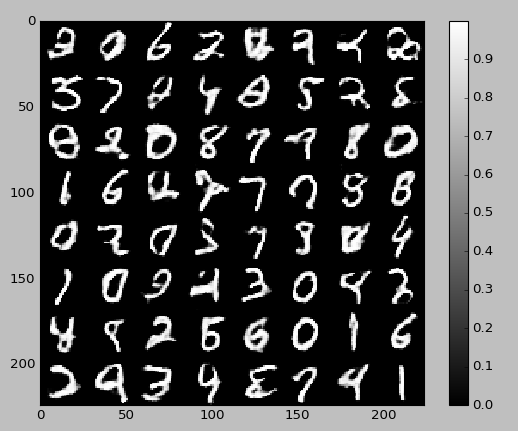

In [3]:
from IPython.display import Image
Image("/home/tuna/Pictures/generated_mnist_screeshot.png")

# Model Declaration

#### Global Variables

In [3]:
#
# -------------------------------------------
#
# Global variables

im_len = 784
batch_size = 128
z_dim = 10

#### TF Layers

In [4]:
#
# ==================================================================
# ==================================================================
# ==================================================================
#

def linear( in_var, output_size, name="linear", stddev=0.02, bias_val=0.0 ):
    shape = in_var.get_shape().as_list()

    with tf.variable_scope( name ):
        W = tf.get_variable( "W", [shape[1], output_size], tf.float32,
                              tf.random_normal_initializer( stddev=stddev ) )
        b = tf.get_variable( "b", [output_size],
                             initializer=tf.constant_initializer( bias_val ) )

        return tf.matmul( in_var, W ) + b

def lrelu( x, leak=0.2, name="lrelu" ):
    return tf.maximum( x, leak*x )

def deconv2d( in_var, output_shape, name="deconv2d", stddev=0.02, bias_val=0.0 ):
    k_w = 5  # filter width/height
    k_h = 5
    d_h = 2  # x,y strides
    d_w = 2

    # [ height, width, in_channels, number of filters ]
    var_shape = [ k_w, k_h, output_shape[-1], in_var.get_shape()[-1] ]

    with tf.variable_scope( name ):    
        W = tf.get_variable( "W", var_shape,
                             initializer=tf.truncated_normal_initializer( stddev=0.02 ) )
        b = tf.get_variable( "b", [output_shape[-1]],
                             initializer=tf.constant_initializer( bias_val ) )

        deconv = tf.nn.conv2d_transpose( in_var, W, output_shape=output_shape, strides=[1, d_h, d_w, 1] )
        deconv = tf.reshape( tf.nn.bias_add( deconv, b), deconv.get_shape() )
    
        return deconv

def conv2d( in_var, output_dim, name="conv2d" ):
    k_w = 5  # filter width/height
    k_h = 5
    d_h = 2  # x,y strides
    d_w = 2

    with tf.variable_scope( name ):
        W = tf.get_variable( "W", [k_h, k_w, in_var.get_shape()[-1], output_dim],
                             initializer=tf.truncated_normal_initializer(stddev=0.02) )
        b = tf.get_variable( "b", [output_dim], initializer=tf.constant_initializer(0.0) )

        conv = tf.nn.conv2d( in_var, W, strides=[1, d_h, d_w, 1], padding='SAME' )
        conv = tf.reshape( tf.nn.bias_add( conv, b ), conv.get_shape() )

        return conv

#
# ==================================================================
# ==================================================================
# ==================================================================
#

# the generator should accept a (tensor of multiple) 'z' and return an image
# z will be [None,z_dim]

def gen_model( zs ):
    
    h1 = tf.nn.relu(linear(zs, 128 * 7 * 7, name="g_linear_h1" ))
    
    #  TODO: I don't understand what dimensions to reshape to here
    h1 = tf.reshape( h1, [ batch_size, 7, 7, 128 ] )
    d2 = tf.nn.relu(deconv2d(h1, [batch_size,14,14,128], name="g_deconv2d_d2" ))
    d3 = tf.sigmoid(deconv2d(d2, [batch_size,28,28,1], name="g_deconv2d_d3" ))
    
    d3 = tf.reshape(d3, [batch_size,784])
    
    return d3











# -------------------------------------------
    
# the discriminator should accept a (tensor of muliple) images and
# return a probability that the image is real
# imgs will be [None,784]

def disc_model( imgs ):
    
    imgs = tf.reshape( imgs, [ batch_size, 28, 28, 1 ] )
    h0 = lrelu(conv2d(imgs, 32, name="d_conv2d_h0" ))
    h1 = lrelu(conv2d(h0, 64, name="d_conv2d_h1" ))
    h1 = tf.reshape( h1, [ batch_size, -1 ] )
    
    h2 = linear(h1, 1024, name="d_linear_h2" )
    h3 = tf.sigmoid(linear(h2, 1, name="d_linear_h3" ))

    return h3





#### Computation Graph

In [5]:
#
# ==================================================================
# ==================================================================
# ==================================================================
#

# Create your computation graph, cost function, and training steps here!

# Placeholders should be named 'z' and ''true_images'
# Training ops should be named 'd_optim' and 'g_optim'
# The output of the generator should be named 'sample_images'

z = tf.placeholder( tf.float32, shape=[None, z_dim] )
true_images = tf.placeholder( tf.float32, shape=[None, im_len] )





with tf.name_scope("generator") as gen_scope:

    #  should be final generator output, to be passed to discriminator   
    sample_images = gen_model(z)

    

# with tf.name_scope("Discriminator") as dis_scope:
#====================================================
#  TODO:  need to fix this so that I'm reusing the variables
#  between these two discriminators, somehow I need to use reuse_variables
#  in my layers for this model... they say it should
#  only be a few lines of code.....
with tf.variable_scope("discriminator") as disc_var_scope:
    sample_im_probs = disc_model(sample_images)
    disc_var_scope.reuse_variables()
    true_im_probs = disc_model(true_images)
#====================================================







#============================================================
#  GENERATOR Loss
#============================================================


with tf.name_scope("generatorloss") as gen_loss_scope:

    g_loss = -1.0 * tf.reduce_mean(tf.log(sample_im_probs))


    #  generator optimizer
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if 'g_' in var.name]
    g_optim = tf.train.AdamOptimizer( 0.0002, beta1=0.5 ).minimize( g_loss, var_list=g_vars )


    
    
    
    
    
    
    
    
    
    
    
#============================================================    
#  DISCRIMINATOR Loss
#============================================================


with tf.name_scope("discriminatorloss") as gen_loss_scope:

    
    d_loss_part_1 = tf.log(tf.reduce_mean(true_im_probs))
    d_loss_part_2 = tf.log(1.0 - tf.reduce_mean(sample_im_probs))
    
    
    d_loss = -1.0 * (tf.log(tf.reduce_mean(true_im_probs)) + tf.log(1.0 - tf.reduce_mean(sample_im_probs)) )

    #  discriminator optimizer
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if 'd_' in var.name]
    d_optim = tf.train.AdamOptimizer( 0.0002, beta1=0.5 ).minimize( d_loss, var_list=d_vars )




    
with tf.name_scope("accuracy") as acc_scope:
    # num_correct_pred = 0



    # num_correct = tf.reduce_sum(tf.cast(tf.greater_equal(true_im_probs, 0.5), tf.float32))
    # num_correct += tf.reduce_sum(tf.cast(tf.less(sample_im_probs, 0.5), tf.float32))
    # d_acc = tf.cast(num_correct, tf.float32) / tf.cast(tf.shape(true_im_probs)[0] + tf.shape(sample_im_probs)[0], 
    #                                                   tf.float32)


    d_true_acc = tf.reduce_mean(tf.cast(tf.greater(true_im_probs, 0.5), tf.float32))
    d_fake_acc = tf.reduce_mean(tf.cast(tf.less(sample_im_probs, 0.5), tf.float32))
    d_acc = tf.truediv(tf.add(d_true_acc, d_fake_acc), 2.0)

    



# Run/Evaluate Model

In [ ]:
#
# ==================================================================
# ==================================================================
# ==================================================================
#






sess = tf.Session()
sess.run( tf.initialize_all_variables() )

summary_writer = tf.train.SummaryWriter( "./tf_logs_final", graph=sess.graph )
acc_summary = tf.scalar_summary( 'accuracy_at_step', d_acc )
g_loss_summary = tf.scalar_summary( 'g_loss', g_loss )
d_loss_summary = tf.scalar_summary( 'd_loss', d_loss )
d_loss_part_1_summary = tf.scalar_summary( 'd_loss_part_1', d_loss_part_1 )
d_loss_part_1_summary = tf.scalar_summary( 'd_loss_part_2', d_loss_part_2 )
merged_summary_op = tf.merge_all_summaries()

print ("      d_loss, g_loss, d_acc")


for i in range( 5000 ):
    batch = mnist.train.next_batch( batch_size )
    batch_images = batch[0]

    sampled_zs = np.random.uniform( low=-1, high=1, size=(batch_size, z_dim) ).astype( np.float32 )
    sess.run( d_optim, feed_dict={ z:sampled_zs, true_images: batch_images } )

    for j in range(3):
        sampled_zs = np.random.uniform( low=-1, high=1, size=(batch_size, z_dim) ).astype( np.float32 )
        sess.run( g_optim, feed_dict={ z:sampled_zs } )
    
#     if i%10==0:
    if True:
        summary, d_acc_val,d_loss_val,g_loss_val = sess.run( [merged_summary_op, d_acc,d_loss,g_loss],
                                                    feed_dict={ z:sampled_zs, true_images: batch_images } )
        summary_writer.add_summary(summary, i)

        if i%10==0:
            print ("%d\t%.2f %.2f %.2f" % ( i, d_loss_val, g_loss_val, d_acc_val ))


    
summary_writer.close()



#
#  show some results
#
sampled_zs = np.random.uniform( -1, 1, size=(batch_size, z_dim) ).astype( np.float32 )
simgs = sess.run( sample_images, feed_dict={ z:sampled_zs } )
simgs = simgs[0:64,:]

tiles = []
for i in range(0,8):
    tiles.append( np.reshape( simgs[i*8:(i+1)*8,:], [28*8,28] ) )
plt.imshow( np.hstack(tiles), interpolation='nearest', cmap=matplotlib.cm.gray )
plt.colorbar()
plt.show()

      d_loss, g_loss, d_acc
0	1.35 0.74 0.50
10	0.64 1.33 0.99
20	0.65 0.98 0.98
30	0.45 1.47 0.98
40	0.66 1.22 0.88
50	1.17 1.42 0.66
60	0.74 1.23 0.88
70	0.53 1.71 0.92
80	0.42 2.32 0.95
90	0.48 1.73 0.95
100	0.52 1.67 0.92
110	0.84 1.04 0.75
120	0.82 2.01 0.75
130	0.89 1.60 0.73
140	1.55 0.30 0.55
150	0.84 1.88 0.76
160	0.68 2.20 0.79
170	0.55 1.62 0.83
180	0.49 1.77 0.88
190	0.73 1.13 0.79
200	1.03 1.04 0.64
210	0.92 1.55 0.69
220	0.71 2.27 0.78
230	0.89 1.79 0.67
240	1.41 1.12 0.52
250	1.53 1.20 0.51
260	1.26 1.54 0.55
270	0.97 1.45 0.68
280	0.98 1.74 0.68
290	1.24 1.01 0.52
300	1.32 1.68 0.60
310	1.94 0.93 0.39
320	2.18 0.87 0.36
330	2.47 0.46 0.23
340	1.65 1.82 0.56
350	1.31 1.24 0.55
360	1.36 0.82 0.52
370	1.22 1.22 0.56
380	0.74 1.89 0.76
390	0.91 1.36 0.75
400	1.41 0.88 0.49
410	1.39 1.03 0.50
420	1.31 1.76 0.56
430	0.89 1.70 0.72
440	1.03 1.87 0.66
450	1.13 1.87 0.60
460	1.27 1.57 0.58
470	1.36 1.59 0.57
480	1.36 1.22 0.54
490	1.29 1.29 0.57
500	1.14 1.39 0.62
510	0.92 2.05 